In [1]:
import os
from pathlib import Path

path = Path(os.getcwd())
os.chdir(path.parent.absolute())

import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import pandas_ta as ta
import vectorbt as vbt
import mt4_hst
from stock_env.feature.feature_extractor import TrendFeatures

In [2]:
cheight, cwidth = 500, 1000  # Adjust as needed for Chart Height and Width
vbt.settings.set_theme(
    "seaborn"
)  # Options: "light" (Default), "dark" (my fav), "seaborn"

# Must be set
vbt.settings.portfolio["freq"] = "1D"  # Daily

# Predefine vectorbt Portfolio settings
vbt.settings.portfolio["init_cash"] = 1e4
vbt.settings.portfolio["fees"] = 0.0015  # 0.25%
vbt.settings.portfolio["slippage"] = 0.0015  # 0.25%
vbt.settings.portfolio["size"] = 100
# vbt.settings.portfolio["accumulate"] = False
vbt.settings.portfolio["allow_partial"] = False

In [4]:
ticker = "FPT"
benchmark = "VNINDEX"
# df = mt4_hst.read_hst("stock_env/datasets/FPT1440.hst")

benchmark = mt4_hst.read_hst("stock_env/datasets/" + benchmark + "1440.hst")
benchmark = benchmark[["time", "close"]].rename(columns={"close": "benchmark"})
df = mt4_hst.read_hst("stock_env/datasets/" + ticker + "1440.hst")
df = df.merge(benchmark, how="inner", on="time")
df = TrendFeatures().preprocess(df, asbool=True, return_all=True)
df.index = df["time"]
# df.to_csv('temp/signal/' + ticker + '.csv', index=False)

# Backtest

In [5]:
from stock_env.utils import create_performance

# Asset Portfolio from Trade Signals
assetpf_signals = vbt.Portfolio.from_signals(
    df.close,
    entries=df.TS_Entries,
    exits=df.TS_Exits,
)
assetpf_signals.stats(settings=dict(benchmark_rets=df.benchmark.pct_change()))

Start                         2007-03-01 00:00:00
End                           2022-07-25 00:00:00
Period                         3838 days 00:00:00
Start Value                               10000.0
End Value                            16252.525321
Total Return [%]                        62.525253
Benchmark Return [%]                        5.826
Max Gross Exposure [%]                  55.261116
Total Fees Paid                        162.192055
Max Drawdown [%]                         9.130309
Max Drawdown Duration           636 days 00:00:00
Total Trades                                   26
Total Closed Trades                            26
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            61.538462
Best Trade [%]                         120.240429
Worst Trade [%]                         -7.369566
Avg Winning Trade [%]                   22.712042
Avg Losing Trade [%]                     -3.70189



    Annual return     :  3.24%
    Cumulative return :  62.53%
    Sharpe ratio      :  0.72
    Maximum Drawdown  : -9.13%
    Annual Volatility :  4.55%
    Value-At-Risk     :  nan%
    


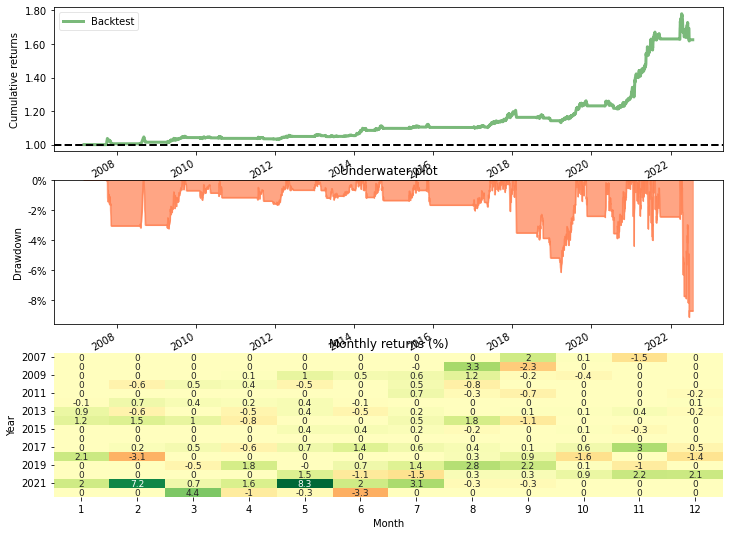

In [6]:
values = assetpf_signals.value()
values.index = df["time"]
returns = values.pct_change()
create_performance(returns)

In [7]:
fig = df.close.vbt.plot(
    trace_kwargs=dict(name=ticker), autosize=False, width=1000, height=500
)
assetpf_signals.positions.plot(close_trace_kwargs=dict(visible=False), fig=fig)

FigureWidget({
    'data': [{'name': 'FPT',
              'showlegend': True,
              'type': 'scatter',…

In [8]:
values.vbt.drawdowns.plot(top_n=3)

FigureWidget({
    'data': [{'line': {'color': 'rgb(76,114,176)'},
              'showlegend': False,
        …